In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import numpy as np

In [2]:
def add_season_to_df(df):
    df = df.reset_index()
    df["season"] = np.nan
    df.loc[df.time.dt.month.isin([12, 1, 2]), "season"] = "DJF"
    df.loc[df.time.dt.month.isin([3, 4, 5]), "season"] = "MAM"
    df.loc[df.time.dt.month.isin([6, 7, 8]), "season"] = "JJA"
    df.loc[df.time.dt.month.isin([9, 10, 11]), "season"] = "SON"
    return df

In [3]:
init = "00"
years = ["2018", "2019", "2020", "2021"]
savedir = "/home/lgaudet/AI2ES/Processed_Data/Forecast_and_Error/"

nam_fcast_and_error = []
gfs_fcast_and_error = []
hrrr_fcast_and_error = []

for year in years:
    print(year)
    nam_fcast_and_error.append(
        pd.read_parquet(f"{savedir}nam_fcast_and_error_df_{init}z_{year}.parquet")
    )
    gfs_fcast_and_error.append(
        pd.read_parquet(f"{savedir}gfs_fcast_and_error_df_{init}z_{year}.parquet")
    )
    hrrr_fcast_and_error.append(
        pd.read_parquet(f"{savedir}hrrr_fcast_and_error_df_{init}z_{year}.parquet")
    )

nam_fcast_and_error_df = pd.concat(nam_fcast_and_error)
gfs_fcast_and_error_df = pd.concat(gfs_fcast_and_error)
hrrr_fcast_and_error_df = pd.concat(hrrr_fcast_and_error)

2018
2019
2020
2021


In [4]:
nam_fcast_and_error_df = add_season_to_df(nam_fcast_and_error_df)
gfs_fcast_and_error_df = add_season_to_df(gfs_fcast_and_error_df)
hrrr_fcast_and_error_df = add_season_to_df(hrrr_fcast_and_error_df)

In [5]:
hrrr_fcast_and_error_df.keys()

Index(['station', 'valid_time', 'time', 't2m_HRRR', 'd2m_HRRR', 'u_total_HRRR',
       'u_dir_HRRR', 'latitude', 'longitude', 'new_tp_HRRR', 'mslma_HRRR',
       'orog', 't2m_error', 'd2m_error', 'u_total_error', 'u_dir_error',
       'new_tp_error', 'mslma_error', 't2m_nysm', 'd2m_nysm', 'u_total_nysm',
       'u_dir_nysm', 'new_tp_nysm', 'mslma_nysm', 'lead_time_DAY',
       'lead_time_HOUR', 'lead_time_ONLY_HOURS', 'season'],
      dtype='object')

In [6]:
# sns.relplot(data=hrrr_fcast_and_error_df, x='u_total_HRRR', y='u_total_error', hue='season', col='season', kind="scatter")

In [7]:
# sns.boxplot(data=hrrr_fcast_and_error_df, x='season', y='u_total_HRRR', hue='season')

In [8]:
def cut_var_range(df, model, var):
    if var == "t2m":
        var_range = np.arange(-40, 41, 5)
        include_lowest = True
    if var == "u_total":
        var_range = np.arange(0, 23, 2)
        include_lowest = False

    df[f"{var}_{model}_range"] = pd.cut(
        df[f"{var}_{model}"], var_range, include_lowest=include_lowest
    )
    df[f"{var}_nysm_range"] = pd.cut(
        df[f"{var}_nysm"], var_range, include_lowest=include_lowest
    )
    return df

In [9]:
def get_seasonal_df(df, model, col_name):
    seasons_df = df.loc["DJF"][[col_name]].rename(
        columns={f"{col_name}": f"DJF - {model}"}
    )
    seasons_df[f"MAM - {model}"] = df.loc["MAM"][[f"{col_name}"]]
    seasons_df[f"JJA - {model}"] = df.loc["JJA"][[f"{col_name}"]]
    seasons_df[f"SON - {model}"] = df.loc["SON"][[f"{col_name}"]]
    return seasons_df

In [10]:
def get_seasons_mean_std(df, model, var):
    df = df.copy()
    df = cut_var_range(df, model, var)

    seasons_mean_std = pd.DataFrame()
    seasons_mean_std = (
        df.groupby(["season", f"{var}_{model}_range"])[[f"{var}_error"]]
        .mean()
        .rename({f"{var}_error": f"{var}_error_mean"})
    )
    seasons_mean_std[f"{var}_std"] = df.groupby(["season", f"{var}_{model}_range"])[
        [f"{var}_error"]
    ].std()
    seasons_mean_std[f"{var}_count"] = df.groupby(["season", f"{var}_{model}_range"])[
        [f"{var}_error"]
    ].count()
    obs_in_bin = (
        df[df[f"{var}_{model}_range"] == df[f"{var}_nysm_range"]]
        .groupby(["season", f"{var}_{model}_range"])[["station"]]
        .count()
    )
    fcasts_in_bin = df.groupby(["season", f"{var}_{model}_range"])[["station"]].count()
    seasons_mean_std["per_obs_in_bin"] = obs_in_bin / fcasts_in_bin
    seasons_mean_std["fcasts_in_bin"] = fcasts_in_bin

    seasons_count = get_seasonal_df(seasons_mean_std, model, f"{var}_count")
    seasons_per_obs_bin = get_seasonal_df(seasons_mean_std, model, "per_obs_in_bin")
    seasons_mean_v2 = get_seasonal_df(seasons_mean_std, model, f"{var}_error")
    seasons_std_v2 = get_seasonal_df(seasons_mean_std, model, f"{var}_std")
    seasons_fcast_count = get_seasonal_df(seasons_mean_std, model, "fcasts_in_bin")

    return (
        seasons_mean_v2.T,
        seasons_std_v2.T,
        seasons_count.T,
        seasons_per_obs_bin.T,
        seasons_fcast_count.T,
    )

In [11]:
new_col_order_all = [
    "DJF - GFS",
    "DJF - NAM",
    "DJF - HRRR",
    "MAM - GFS",
    "MAM - NAM",
    "MAM - HRRR",
    "JJA - GFS",
    "JJA - NAM",
    "JJA - HRRR",
    "SON - GFS",
    "SON - NAM",
    "SON - HRRR",
]

new_col_order_gfsnam = [
    "DJF - GFS",
    "DJF - NAM",
    "MAM - GFS",
    "MAM - NAM",
    "JJA - GFS",
    "JJA - NAM",
    "SON - GFS",
    "SON - NAM",
]

In [12]:
(
    nam_seasons_mean_v2,
    nam_seasons_std_v2,
    nam_seasons_count,
    nam_per_obs_bin,
    nam_fcast_count,
) = get_seasons_mean_std(
    nam_fcast_and_error_df[nam_fcast_and_error_df["lead_time_ONLY_HOURS"] <= 18],
    "NAM",
    "t2m",
)
(
    gfs_seasons_mean_v2,
    gfs_seasons_std_v2,
    gfs_seasons_count,
    gfs_per_obs_bin,
    gfs_fcast_count,
) = get_seasons_mean_std(
    gfs_fcast_and_error_df[gfs_fcast_and_error_df["lead_time_ONLY_HOURS"] <= 18],
    "GFS",
    "t2m",
)
(
    hrrr_seasons_mean_v2,
    hrrr_seasons_std_v2,
    hrrr_seasons_count,
    hrrr_per_obs_bin,
    hrrr_fcast_count,
) = get_seasons_mean_std(
    hrrr_fcast_and_error_df[hrrr_fcast_and_error_df["lead_time_ONLY_HOURS"] <= 18],
    "HRRR",
    "t2m",
)

all_models_seasons_mean = pd.concat(
    [gfs_seasons_mean_v2, nam_seasons_mean_v2, hrrr_seasons_mean_v2]
)
all_models_seasons_std = pd.concat(
    [gfs_seasons_std_v2, nam_seasons_std_v2, hrrr_seasons_std_v2]
)
all_models_seasons_count = pd.concat(
    [gfs_seasons_count, nam_seasons_count, hrrr_seasons_count]
)
all_models_seasons_per_obs_bin = pd.concat(
    [gfs_per_obs_bin, nam_per_obs_bin, hrrr_per_obs_bin]
)
all_models_seasons_fcast_count = pd.concat(
    [gfs_fcast_count, nam_fcast_count, hrrr_fcast_count]
)

# new column order
all_models_seasons_mean_reordered = all_models_seasons_mean.T[new_col_order_all]
all_models_seasons_per_obs_bin = all_models_seasons_per_obs_bin.T[new_col_order_all]

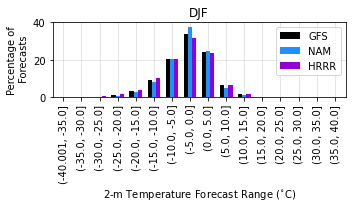

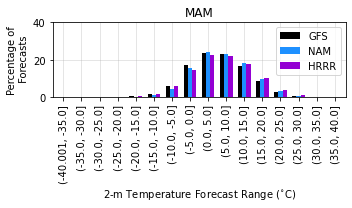

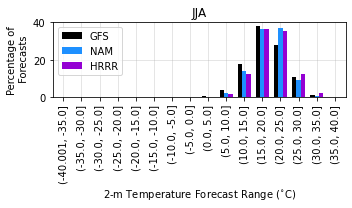

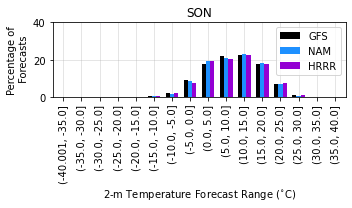

In [13]:
per_data = (
    100 * all_models_seasons_fcast_count.T / all_models_seasons_fcast_count.sum(axis=1)
)

seasons = ["DJF", "MAM", "JJA", "SON"]
for season in seasons:
    per_data[[f"{season} - GFS", f"{season} - NAM", f"{season} - HRRR"]].rename(
        columns={
            f"{season} - GFS": "GFS",
            f"{season} - NAM": "NAM",
            f"{season} - HRRR": "HRRR",
        }
    ).plot.bar(
        figsize=(5, 3), color=["k", "dodgerblue", "darkviolet"], width=0.7, zorder=2
    )
    plt.grid(True, alpha=0.4, zorder=1)
    plt.title(season)
    plt.ylabel("Percentage of\n Forecasts")
    plt.xlabel("2-m Temperature Forecast Range ($^{\circ}$C)")
    plt.ylim([0, 40])
    plt.tight_layout()
    # plt.savefig(f'../Figures/t2m_per_forecasts_in_range_barplot_{season}.png', dpi=200, facecolor='white', transparent=False)

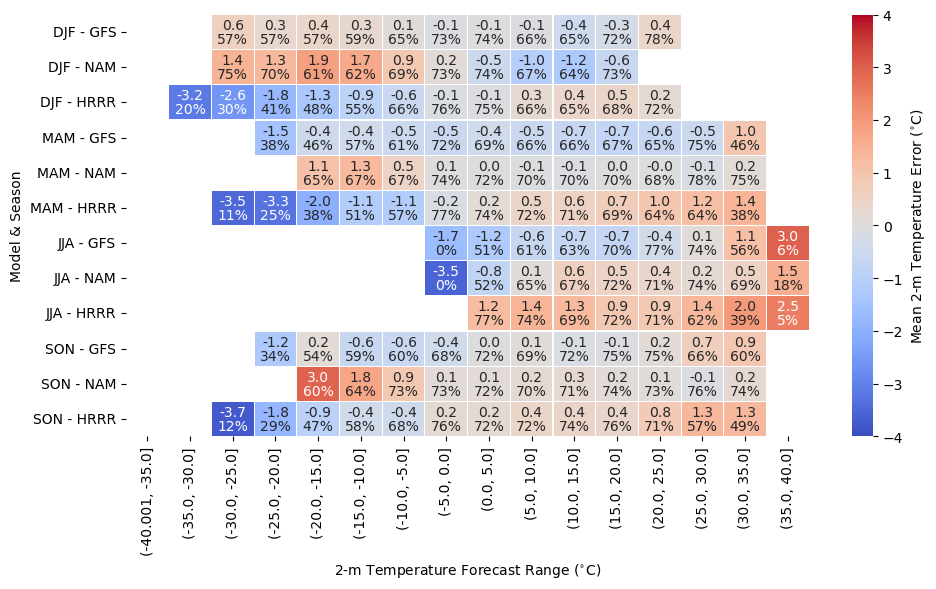

In [14]:
plt.figure(figsize=(10, 6), dpi=100)
sns.heatmap(
    all_models_seasons_mean_reordered[all_models_seasons_count.T > 2].T,
    vmin=-4,
    vmax=4,
    fmt=".0%",
    cmap=cm.coolwarm,
    cbar_kws={"label": "Mean 2-m Temperature Error ($^{\circ}$C)"},
    linewidths=0.1,
    cbar=True,
)
sns.heatmap(
    all_models_seasons_mean_reordered[all_models_seasons_count.T > 2].T,
    vmin=-4,
    vmax=4,
    annot=all_models_seasons_mean_reordered.T,
    fmt=".1f",
    cmap=cm.coolwarm,
    cbar_kws={"label": "Mean 2-m Temperature Error ($^{\circ}$C)"},
    linewidths=0.1,
    annot_kws={"va": "bottom"},
    cbar=False,
)
sns.heatmap(
    all_models_seasons_mean_reordered[all_models_seasons_count.T > 2].T,
    vmin=-4,
    vmax=4,
    annot=all_models_seasons_per_obs_bin.T,
    fmt=".0%",
    cmap=cm.coolwarm,
    cbar_kws={"label": "Mean 2-m Temperature Error ($^{\circ}$C)"},
    linewidths=0.1,
    annot_kws={"va": "top"},
    cbar=False,
)
plt.ylabel("Model & Season")
plt.xlabel("2-m Temperature Forecast Range ($^{\circ}$C)")
plt.tight_layout()
# plt.savefig(f'../Figures/t2m_mean_seasonal_error_temp_range_reordered_fhleq18_perobsbin_{init}z.png', dpi=200, facecolor='white', transparent=False)

In [15]:
# # some subzero temperature forecasts occurred in the warm season - just looking at when and where these occurred

# subzero_JJA = nam_fcast_and_error_df[(nam_fcast_and_error_df['t2m_NAM']<=0) & (nam_fcast_and_error_df['season']=='JJA')][['station','latitude','longitude','orog']]
# print(nam_fcast_and_error_df[(nam_fcast_and_error_df['t2m_NAM']<=0) & (nam_fcast_and_error_df['season']=='JJA')]['valid_time'].unique())
# nysm_sites = hrrr_fcast_and_error_df.groupby('station')[['latitude','longitude','orog']].mean()

# plt.scatter(nysm_sites.longitude, nysm_sites.latitude, c='k')
# plt.scatter(subzero_JJA.longitude, subzero_JJA.latitude, c='red')

In [16]:
# all temperature ranges
all_models_seasons_mean_reordered[all_models_seasons_count.T > 2].mean()

DJF - GFS     0.110860
DJF - NAM     0.398943
DJF - HRRR   -0.757042
MAM - GFS    -0.485736
MAM - NAM     0.258097
MAM - HRRR   -0.433090
JJA - GFS    -0.107720
JJA - NAM    -0.050013
JJA - HRRR    1.453389
SON - GFS    -0.080494
SON - NAM     0.613523
SON - HRRR   -0.158820
dtype: float64

In [17]:
# below freezing
all_models_seasons_mean_reordered[all_models_seasons_count.T > 2].iloc[0:8].mean()

DJF - GFS     0.276854
DJF - NAM     1.223110
DJF - HRRR   -1.481948
MAM - GFS    -0.669433
MAM - NAM     0.727772
MAM - HRRR   -1.855619
JJA - GFS    -1.667625
JJA - NAM    -3.545080
JJA - HRRR         NaN
SON - GFS    -0.528488
SON - NAM     1.437703
SON - HRRR   -1.172864
dtype: float64

In [18]:
# above freezing
all_models_seasons_mean_reordered[all_models_seasons_count.T > 2].iloc[8:].mean()

DJF - GFS    -0.088332
DJF - NAM    -0.837306
DJF - HRRR    0.257827
MAM - GFS    -0.354524
MAM - NAM    -0.010288
MAM - HRRR    0.786220
JJA - GFS     0.087268
JJA - NAM     0.386870
JJA - HRRR    1.453389
SON - GFS     0.239501
SON - NAM     0.142563
SON - HRRR    0.710360
dtype: float64

In [19]:
(
    nam_seasons_mean_v2,
    nam_seasons_std_v2,
    nam_seasons_count,
    nam_per_obs_bin,
    nam_fcast_count,
) = get_seasons_mean_std(
    nam_fcast_and_error_df[nam_fcast_and_error_df["lead_time_ONLY_HOURS"] <= 18],
    "NAM",
    "u_total",
)
(
    gfs_seasons_mean_v2,
    gfs_seasons_std_v2,
    gfs_seasons_count,
    gfs_per_obs_bin,
    gfs_fcast_count,
) = get_seasons_mean_std(
    gfs_fcast_and_error_df[gfs_fcast_and_error_df["lead_time_ONLY_HOURS"] <= 18],
    "GFS",
    "u_total",
)
(
    hrrr_seasons_mean_v2,
    hrrr_seasons_std_v2,
    hrrr_seasons_count,
    hrrr_per_obs_bin,
    hrrr_fcast_count,
) = get_seasons_mean_std(
    hrrr_fcast_and_error_df[hrrr_fcast_and_error_df["lead_time_ONLY_HOURS"] <= 18],
    "HRRR",
    "u_total",
)

all_models_seasons_mean = pd.concat(
    [gfs_seasons_mean_v2, nam_seasons_mean_v2, hrrr_seasons_mean_v2]
)
all_models_seasons_std = pd.concat(
    [gfs_seasons_std_v2, nam_seasons_std_v2, hrrr_seasons_std_v2]
)
all_models_seasons_count = pd.concat(
    [gfs_seasons_count, nam_seasons_count, hrrr_seasons_count]
)
all_models_seasons_per_obs_bin = pd.concat(
    [gfs_per_obs_bin, nam_per_obs_bin, hrrr_per_obs_bin]
)

all_models_seasons_mean_reordered = all_models_seasons_mean.T[new_col_order_all]
all_models_seasons_per_obs_bin = all_models_seasons_per_obs_bin.T[new_col_order_all]

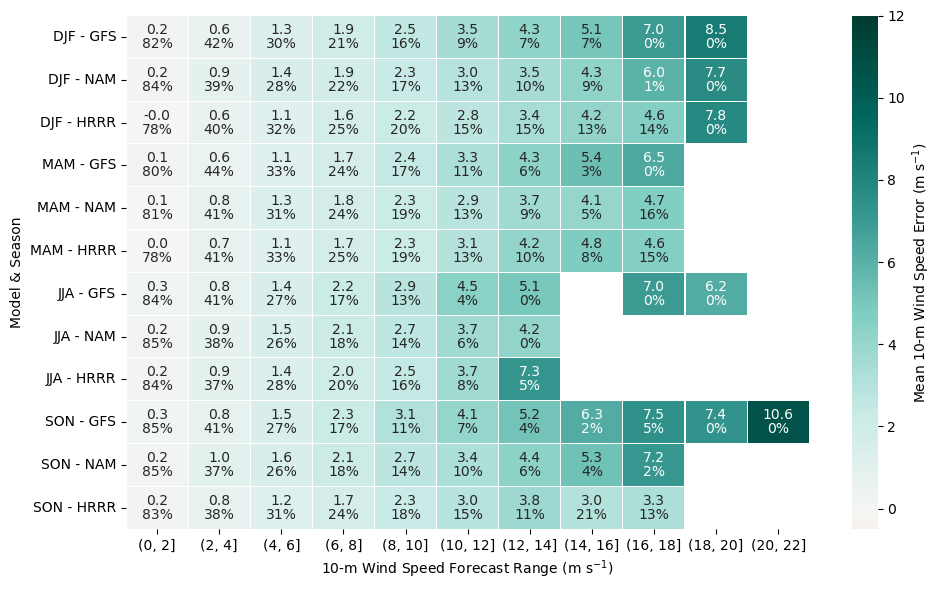

In [22]:
cmap = cm.BrBG

plt.figure(figsize=(10, 6), dpi=100)
sns.heatmap(
    all_models_seasons_mean_reordered[all_models_seasons_count.T > 2].T,
    vmin=-0.5,
    vmax=12,
    fmt=".0%",
    cmap=cmap,
    center=0,
    cbar_kws={"label": "Mean 10-m Wind Speed Error (m s$^{-1}$)"},
    linewidths=0.1,
    cbar=True,
)
sns.heatmap(
    all_models_seasons_mean_reordered[all_models_seasons_count.T > 2].T,
    vmin=-0.5,
    vmax=12,
    annot=all_models_seasons_mean_reordered.T,
    fmt=".1f",
    cmap=cmap,
    center=0,
    cbar_kws={"label": "Mean 10-m Wind Speed Error (m s$^{-1}$)"},
    linewidths=0.1,
    annot_kws={"va": "bottom"},
    cbar=False,
)
sns.heatmap(
    all_models_seasons_mean_reordered[all_models_seasons_count.T > 2].T,
    vmin=-0.5,
    vmax=12,
    annot=all_models_seasons_per_obs_bin.T,
    fmt=".0%",
    cmap=cmap,
    center=0,
    cbar_kws={"label": "Mean 10-m Wind Speed Error (m s$^{-1}$)"},
    linewidths=0.1,
    annot_kws={"va": "top"},
    cbar=False,
)
plt.ylabel("Model & Season")
plt.xlabel("10-m Wind Speed Forecast Range (m s$^{-1}$)")
plt.tight_layout()
plt.savefig(
    f"../Figures/u_total_mean_seasonal_error_range_fhleq18_perobsbin_{init}z.png",
    dpi=200,
    facecolor="white",
    transparent=False,
)

### > 18 and <=84

In [18]:
(
    nam_seasons_mean_v2,
    nam_seasons_std_v2,
    nam_seasons_count,
    nam_per_obs_bin,
    nam_fcast_count,
) = get_seasons_mean_std(
    nam_fcast_and_error_df[
        (nam_fcast_and_error_df["lead_time_ONLY_HOURS"] > 18)
        & (nam_fcast_and_error_df["lead_time_ONLY_HOURS"] <= 84)
    ],
    "NAM",
    "t2m",
)
(
    gfs_seasons_mean_v2,
    gfs_seasons_std_v2,
    gfs_seasons_count,
    gfs_per_obs_bin,
    gfs_fcast_count,
) = get_seasons_mean_std(
    gfs_fcast_and_error_df[
        (gfs_fcast_and_error_df["lead_time_ONLY_HOURS"] > 18)
        & (gfs_fcast_and_error_df["lead_time_ONLY_HOURS"] <= 84)
    ],
    "GFS",
    "t2m",
)
all_models_seasons_mean = pd.concat([gfs_seasons_mean_v2, nam_seasons_mean_v2])
all_models_seasons_std = pd.concat([gfs_seasons_std_v2, nam_seasons_std_v2])
all_models_seasons_count = pd.concat([gfs_seasons_count, nam_seasons_count])
all_models_seasons_per_obs_bin = pd.concat([gfs_per_obs_bin, nam_per_obs_bin])

new_col_order = [
    "DJF - GFS",
    "DJF - NAM",
    "MAM - GFS",
    "MAM - NAM",
    "JJA - GFS",
    "JJA - NAM",
    "SON - GFS",
    "SON - NAM",
]

all_models_seasons_mean_reordered = all_models_seasons_mean.T[new_col_order_gfsnam]
all_models_seasons_per_obs_bin = all_models_seasons_per_obs_bin.T[new_col_order_gfsnam]

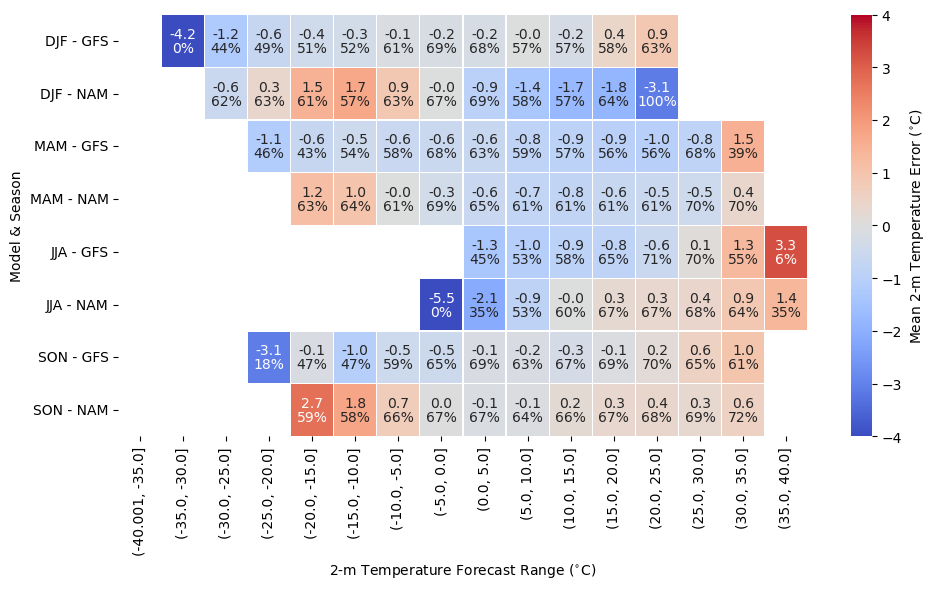

In [19]:
plt.figure(figsize=(10, 6), dpi=100)
sns.heatmap(
    all_models_seasons_mean_reordered[all_models_seasons_count.T > 2].T,
    vmin=-4,
    vmax=4,
    fmt=".0%",
    cmap=cm.coolwarm,
    cbar_kws={"label": "Mean 2-m Temperature Error ($^{\circ}$C)"},
    linewidths=0.1,
    cbar=True,
)
sns.heatmap(
    all_models_seasons_mean_reordered[all_models_seasons_count.T > 2].T,
    vmin=-4,
    vmax=4,
    annot=all_models_seasons_mean_reordered.T,
    fmt=".1f",
    cmap=cm.coolwarm,
    cbar_kws={"label": "Mean 2-m Temperature Error ($^{\circ}$C)"},
    linewidths=0.1,
    annot_kws={"va": "bottom"},
    cbar=False,
)
sns.heatmap(
    all_models_seasons_mean_reordered[all_models_seasons_count.T > 2].T,
    vmin=-4,
    vmax=4,
    annot=all_models_seasons_per_obs_bin.T,
    fmt=".0%",
    cmap=cm.coolwarm,
    cbar_kws={"label": "Mean 2-m Temperature Error ($^{\circ}$C)"},
    linewidths=0.1,
    annot_kws={"va": "top"},
    cbar=False,
)
plt.ylabel("Model & Season")
plt.xlabel("2-m Temperature Forecast Range ($^{\circ}$C)")
plt.tight_layout()
# plt.savefig(f'../Figures/t2m_mean_seasonal_error_temp_range_reordered_fhgt18_perobsbin_{init}z.png', dpi=200, facecolor='white', transparent=False)

In [20]:
# below freezing
all_models_seasons_mean_reordered[all_models_seasons_count.T > 2].iloc[0:8].mean()

DJF - GFS   -1.004776
DJF - NAM    0.642773
MAM - GFS   -0.674990
MAM - NAM    0.472571
JJA - GFS         NaN
JJA - NAM   -5.464970
SON - GFS   -1.035847
SON - NAM    1.303813
dtype: float64

In [23]:
(
    nam_seasons_mean_v2,
    nam_seasons_std_v2,
    nam_seasons_count,
    nam_per_obs_bin,
    nam_fcast_count,
) = get_seasons_mean_std(
    nam_fcast_and_error_df[
        (nam_fcast_and_error_df["lead_time_ONLY_HOURS"] > 18)
        & (nam_fcast_and_error_df["lead_time_ONLY_HOURS"] <= 84)
    ],
    "NAM",
    "u_total",
)
(
    gfs_seasons_mean_v2,
    gfs_seasons_std_v2,
    gfs_seasons_count,
    gfs_per_obs_bin,
    gfs_fcast_count,
) = get_seasons_mean_std(
    gfs_fcast_and_error_df[
        (gfs_fcast_and_error_df["lead_time_ONLY_HOURS"] > 18)
        & (gfs_fcast_and_error_df["lead_time_ONLY_HOURS"] <= 84)
    ],
    "GFS",
    "u_total",
)
all_models_seasons_mean = pd.concat([gfs_seasons_mean_v2, nam_seasons_mean_v2])
all_models_seasons_std = pd.concat([gfs_seasons_std_v2, nam_seasons_std_v2])
all_models_seasons_count = pd.concat([gfs_seasons_count, nam_seasons_count])
all_models_seasons_per_obs_bin = pd.concat([gfs_per_obs_bin, nam_per_obs_bin])

all_models_seasons_mean_reordered = all_models_seasons_mean.T[new_col_order_gfsnam]
all_models_seasons_per_obs_bin = all_models_seasons_per_obs_bin.T[new_col_order_gfsnam]

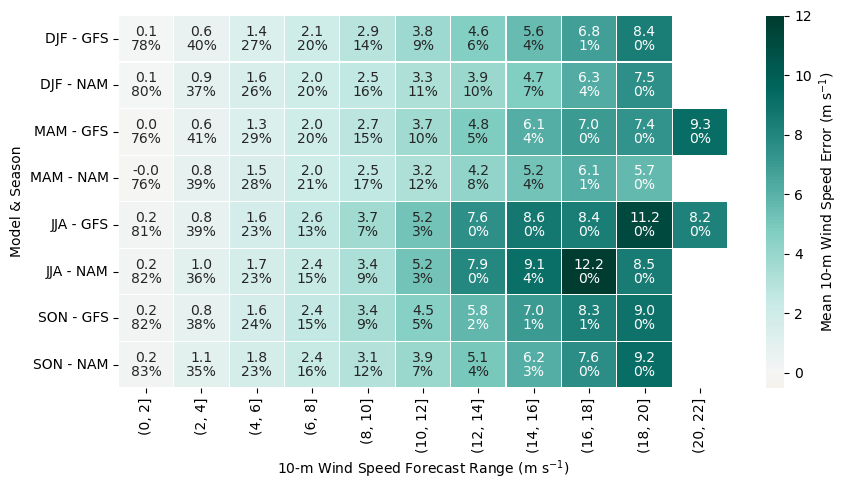

In [24]:
cmap = cm.BrBG

plt.figure(figsize=(9, 5), dpi=100)
sns.heatmap(
    all_models_seasons_mean_reordered[all_models_seasons_count.T > 2].T,
    vmin=-0.5,
    vmax=12,
    fmt=".0%",
    cmap=cmap,
    center=0,
    cbar_kws={"label": "Mean 10-m Wind Speed Error (m s$^{-1}$)"},
    linewidths=0.1,
    cbar=True,
)
sns.heatmap(
    all_models_seasons_mean_reordered[all_models_seasons_count.T > 2].T,
    vmin=-0.5,
    vmax=12,
    annot=all_models_seasons_mean_reordered.T,
    fmt=".1f",
    cmap=cmap,
    center=0,
    cbar_kws={"label": "Mean 10-m Wind Speed Error (m s$^{-1}$)"},
    linewidths=0.1,
    annot_kws={"va": "bottom"},
    cbar=False,
)
sns.heatmap(
    all_models_seasons_mean_reordered[all_models_seasons_count.T > 2].T,
    vmin=-0.5,
    vmax=12,
    annot=all_models_seasons_per_obs_bin.T,
    fmt=".0%",
    cmap=cmap,
    center=0,
    cbar_kws={"label": "Mean 10-m Wind Speed Error (m s$^{-1}$)"},
    linewidths=0.1,
    annot_kws={"va": "top"},
    cbar=False,
)
plt.ylabel("Model & Season")
plt.xlabel("10-m Wind Speed Forecast Range (m s$^{-1}$)")
plt.tight_layout()
# plt.savefig(f'../Figures/u_total_mean_seasonal_error_range_fhgt18_perobsbin_{init}z.png', dpi=200, facecolor='white', transparent=False)